# Genetic optimization of Ridge classifier for the SDSS data

## Load data

In [2]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals
import warnings
import helpers
from helpers import DataSet
import matplotlib as mpl
import os
import random

# Common imports
import pandas as pd
import numpy as np
import seaborn as sns

# Imports for ML
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier, PassiveAggressiveClassifier, RidgeClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import RobustScaler, StandardScaler, MaxAbsScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.decomposition import PCA

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
sns.set_style('whitegrid')

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "results"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)

# Helper functioins and structures
# Ignore useless warnings (see SciPy issue #5998)
warnings.filterwarnings(action="ignore", message="^internal gelsd")

DATA_PATH = "Skyserver_SQL2_27_2018 6_51_39 PM.csv"
RESULTS_FOLDER = "results"

# We load the data. Those that have nothing to do with the features of the objects are ignored.
sdss_data = pd.read_csv(DATA_PATH)

# We have a general look at the features
sdss_data.head(3)

print(sdss_data.columns.values)
sdss_data.drop(['objid', 'run', 'rerun', 'camcol', 'field',
                'specobjid', 'fiberid', 'mjd', 'plate'], axis=1, inplace=True)
sdss_data.head(1)

sdss_df_fe = sdss_data

# Principal Component Analysis
pca = PCA(n_components=3)
ugriz = pca.fit_transform(sdss_df_fe[['u', 'g', 'r', 'i', 'z']])

# update dataframe 
sdss_df_fe = pd.concat((sdss_df_fe, pd.DataFrame(ugriz)), axis=1)
sdss_df_fe.rename({0: 'PCA_1', 1: 'PCA_2', 2: 'PCA_3'}, axis=1, inplace = True)
sdss_df_fe.drop(['u', 'g', 'r', 'i', 'z'], axis=1, inplace=True)
sdss_df_fe.head()

X = sdss_data.drop(['class'], axis=1)
y = sdss_data['class']

class_names = ["GALAXY", "QSO", "STAR"]

std_scaler = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

X_test = std_scaler.fit_transform(X_test.astype(np.float64))
X_train = std_scaler.fit_transform(X_train.astype(np.float64))

['objid' 'ra' 'dec' 'u' 'g' 'r' 'i' 'z' 'run' 'rerun' 'camcol' 'field'
 'specobjid' 'class' 'redshift' 'plate' 'mjd' 'fiberid']


## Optimize

In [8]:
from evolutionary_search import EvolutionaryAlgorithmSearchCV

alpha = np.logspace(-3,4,base=10,num=25).tolist()
alpha.append(1)

paramgrid = {"alpha": alpha,
             "fit_intercept":[True,False],
             "normalize":[True,False],
             "copy_X":[True,False],
             "max_iter":[3000],
             "class_weight":[None, "balanced"],
             "solver":["auto","svd","cholesky","lsqr","sparse_cg","sag","saga"],
             "random_state":[42]
             }

random.seed(1)

cv = EvolutionaryAlgorithmSearchCV(estimator=RidgeClassifier(),
                                   params=paramgrid,
                                   scoring="accuracy",
                                   cv=StratifiedKFold(n_splits=5),
                                   verbose=1,
                                   population_size=50,
                                   gene_mutation_prob=0.10,
                                   gene_crossover_prob=0.5,
                                   tournament_size=3,
                                   generations_number=15,
                                   n_jobs=8,
                                   error_score=0.0)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    result = cv.fit(X, y)

Types [2, 1, 1, 1, 1, 1, 1, 1] and maxint [25, 1, 1, 1, 0, 1, 6, 0] detected


/home/ljosfer/anaconda3/envs/deep/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/ljosfer/anaconda3/envs/deep/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


--- Evolve in 2912 possible combinations ---
gen	nevals	avg     	min   	max  	std     
0  	50    	0.823204	0.4998	0.912	0.112418
1  	36    	0.877924	0.6729	0.912	0.0558317
2  	24    	0.895212	0.6786	0.912	0.0442282
3  	21    	0.911222	0.9069	0.912	0.00138062
4  	29    	0.911108	0.8941	0.912	0.00331662
5  	28    	0.911938	0.9089	0.912	0.000434  
6  	30    	0.911776	0.9008	0.912	0.001568  
7  	32    	0.910574	0.8519	0.912	0.00852734
8  	34    	0.912   	0.912 	0.912	0         
9  	29    	0.907818	0.7212	0.912	0.026723  
10 	28    	0.911934	0.9087	0.912	0.000462  
11 	28    	0.909514	0.7989	0.912	0.0158796 
12 	24    	0.912   	0.912 	0.912	0         
13 	36    	0.91021 	0.8259	0.912	0.0120537 
14 	34    	0.911802	0.9061	0.912	0.000946254
15 	30    	0.911332	0.8796	0.912	0.0045353  
Best individual is: {'alpha': 0.11006941712522103, 'fit_intercept': False, 'normalize': False, 'copy_X': True, 'max_iter': 3000, 'class_weight': None, 'solver': 'cholesky', 'random_state': 42}
with fitness: 0.91

Data Set Type:  Standard Scaled
QuadraticDiscriminantAnalysis
[0.9260493  0.91538974 0.938      0.9179453  0.91861241]
Accuracy: 0.923 (+/- 0.016)
QuadraticDiscriminantAnalysis :
 [[1055   15  176]
 [  19  222    1]
 [  43    2  967]]
              precision    recall  f1-score   support

      GALAXY       0.94      0.85      0.89      1246
         QSO       0.93      0.92      0.92       242
        STAR       0.85      0.96      0.90      1012

   micro avg       0.90      0.90      0.90      2500
   macro avg       0.91      0.91      0.90      2500
weighted avg       0.90      0.90      0.90      2500



By Acc:
QuadraticDiscriminantAnalysis 0.9231993491552662


By Precision(avg=micro):
QuadraticDiscriminantAnalysis 0.8976


By Recall(avg=micro):
QuadraticDiscriminantAnalysis 0.8976


By F1(avg=micro):
QuadraticDiscriminantAnalysis 0.8976


By Precision(avg=macro):
QuadraticDiscriminantAnalysis 0.9062147313360964


By Recall(avg=macro):
QuadraticDiscriminantAnalysis 0.90653281301

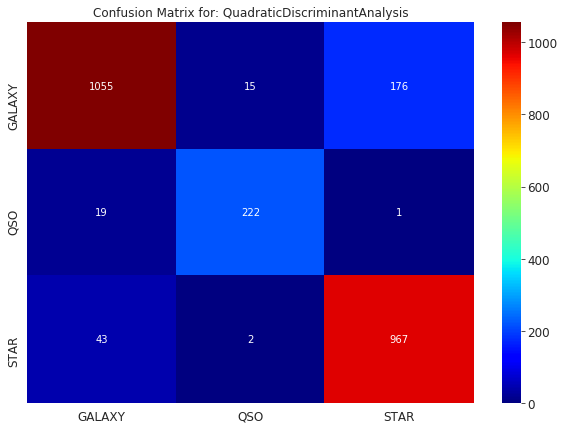

In [3]:
best_indiv = RidgeClassifier(alpha=0.11006941712522103,
                             fit_intercept=False,
                             normalize=False,
                             copy_X=True, 
                             max_iter=3000,
                             class_weight=None,
                             solver='cholesky',
                             random_state=42)

clf_names = ["QuadraticDiscriminantAnalysis"]
class_names = ["GALAXY", "QSO", "STAR"]

clfs=[best_indiv]
data_sets = []
std_scaled_set = DataSet("Standard Scaled", X_train, y_train, X_test, y_test)
data_sets.append(std_scaled_set)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    helpers.learning_loop_for_sets(clfs, clf_names, class_names, data_sets)